In [1]:
# import tensorflow as tf
# # physical_devices = tf.config.experimental.list_physical_devices('GPU')
# # if len(physical_devices) > 0:
# #     tf.config.experimental.set_memory_growth(physical_devices[0], True)
# tf.config.set_visible_devices([], 'GPU')

In [2]:
import breastnet
import os
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sn
warnings.filterwarnings('ignore')

2023-04-28 20:07:49.069591: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
from tensorflow import keras
from tensorflow.keras.layers import *

In [4]:
from tqdm import tqdm
from matplotlib import pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, classification_report, confusion_matrix, roc_curve

from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers.schedules import PolynomialDecay
from tensorflow.keras.applications import VGG16, VGG19, InceptionResNetV2
from tensorflow.keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator

In [48]:
def plot_stats(stats, model_names, labels, y_label, n_classes):
    width = 0.1
    x = [i for i in range(n_classes)]
    fig, ax = plt.subplots(figsize=(2.5 * n_classes, 5))
    ax.set_ylabel(y_label)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    y_ticks = [0.20, 0.40, 0.60, 0.80, 1]
    ax.set_yticks(y_ticks)
    ax.set_yticklabels([str(int(y_tick * 100)) + "%" for y_tick in y_ticks])
    ax.set_ylim([0, 1.07])
    for i in range(len(model_names)):
        ax.bar(
            [clazz + ((i - (len(labels) / 2)) * width) for clazz in x],
            stats[i],
            width,
            label=model_names[i]
        )
    print()
    ax.legend()
    plt.show()

In [6]:
def plot_image(x, label):
    plt.imshow(x)
    plt.xlabel(label)
    plt.grid(False)

In [7]:
def plot_prediction_array(prediction, predicted_class, true_class):
    plt.grid(False)
    plt.xticks(range(len(prediction)))
    plt.yticks([])
    plot = plt.bar(range(len(prediction)), prediction, color="#777777")
    plot[predicted_class].set_color('red')
    plot[true_class].set_color('blue')

In [8]:
def plot_results(indices, x_test, y_test, y_predicted, encoder):
    plt.figure(figsize=(10, 5))
    for i in range(4):
        image_index = indices[i]
        prediction = y_predicted[image_index]
        plt.subplot(2, 4, 2 * i + 1)
        percentage = round(max(prediction) * 100, 2)
        predicted_class = np.argmax(y_predicted[image_index])
        true_class = np.argmax(y_test[image_index])
        predicted_class_label = encoder.inverse_transform([predicted_class])[0]
        true_class_label = encoder.inverse_transform([true_class])[0]
        x_label = str(predicted_class_label) + " " + str(percentage) + "%\n(" + str(true_class_label) + ")"
        plot_image(x_test[image_index], x_label)
        plt.xticks([])
        plt.yticks([])
        plt.subplot(2, 4, 2 * i + 2)
        plot_prediction_array(y_predicted[image_index], predicted_class, true_class)

In [9]:
def plot_roc_curve(y_true, y_probabilities):
    plt.figure(figsize=(6, 6))
    false_positive_rate, true_positive_rate, _ = roc_curve(y_true, y_probabilities) 
    area_under_curve = auc(false_positive_rate, true_positive_rate)
    plt.plot(false_positive_rate, true_positive_rate, label='AUC = {:.3f}'.format(area_under_curve))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend()
    plt.show()


In [10]:
def plot_confusion_matrix(y_true, y_predicted, labels):
    size = len(labels) * 2
    plt.figure(figsize=(size, size))
    sn.heatmap(
        data = confusion_matrix(y_true, y_predicted),
        cmap = "YlGnBu",
        fmt= 'g',
        annot = True,
        xticklabels = labels,
        yticklabels = labels
    )
    plt.xlabel("predicted") 
    plt.ylabel("true")
    plt.show()

In [11]:
def compute_stats(report, n_classes):
    accuracy = report["accuracy"]
    recalls = []
    precisions = []
    for clazz in range(n_classes):
        recalls.append(report[str(clazz)]["recall"]) 
        precisions.append(report[str(clazz)]["precision"]) 
    return accuracy, recalls, precisions

In [12]:
base_data_path =  '/Users/shahid/Documents/DLproject/data/BreaKHis_v1/BreaKHis_v1/histology_slides/breast'

In [13]:
# magnifications = ['40X']
magnifications = ['40X', '100X', '200X', '400X']
classes = ['benign', 'malignant']
sub_classes = {
#     'benign': ['adenosis'],
    'benign': ['adenosis', 'fibroadenoma', 'phyllodes_tumor', 'tubular_adenoma'],
#     'malignant': ['ductal_carcinoma']
    'malignant': ['ductal_carcinoma', 'lobular_carcinoma', 'mucinous_carcinoma', 'papillary_carcinoma']
}

keys = ["binary", "benign", "malignant"]
labels = [classes, sub_classes["benign"], sub_classes["malignant"]]
n_classes = [2, 4, 4]

test_size = 0.3
random_state = 42

In [14]:
dataset = pd.DataFrame()
for clazz in tqdm(classes):
    for sub_clazz in sub_classes[clazz]:
        path = os.path.join(base_data_path, clazz, "SOB", sub_clazz)
        print(path)
        for id in os.listdir(path):
            if id == '.DS_Store':
                continue  # Skip .DS_Store file
            for magnification in magnifications:
                path_to_files = os.path.join(path, id, magnification)
#                 print(path_to_files)
                for file_name in os.listdir(path_to_files):
                    new_row = {
                        'id': id,
                        'path': os.path.join(path_to_files, file_name),
                        'magnification': magnification,
                        'type': sub_clazz,
                        'lesion': clazz
                    }
                    dataset = pd.concat([dataset, pd.DataFrame(new_row, index=[0])], ignore_index=True)

dataset

  0%|                                                     | 0/2 [00:00<?, ?it/s]

/Users/shahid/Documents/DLproject/data/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis
/Users/shahid/Documents/DLproject/data/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma
/Users/shahid/Documents/DLproject/data/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor
/Users/shahid/Documents/DLproject/data/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma


 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  1.06it/s]

/Users/shahid/Documents/DLproject/data/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma
/Users/shahid/Documents/DLproject/data/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma
/Users/shahid/Documents/DLproject/data/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma
/Users/shahid/Documents/DLproject/data/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma


100%|█████████████████████████████████████████████| 2/2 [00:03<00:00,  1.69s/it]


id                                               path   
0     SOB_B_A_14-22549AB  /Users/shahid/Documents/DLproject/data/BreaKHi...  \
1     SOB_B_A_14-22549AB  /Users/shahid/Documents/DLproject/data/BreaKHi...   
2     SOB_B_A_14-22549AB  /Users/shahid/Documents/DLproject/data/BreaKHi...   
3     SOB_B_A_14-22549AB  /Users/shahid/Documents/DLproject/data/BreaKHi...   
4     SOB_B_A_14-22549AB  /Users/shahid/Documents/DLproject/data/BreaKHi...   
...                  ...                                                ...   
7904    SOB_M_PC_14-9146  /Users/shahid/Documents/DLproject/data/BreaKHi...   
7905    SOB_M_PC_14-9146  /Users/shahid/Documents/DLproject/data/BreaKHi...   
7906    SOB_M_PC_14-9146  /Users/shahid/Documents/DLproject/data/BreaKHi...   
7907    SOB_M_PC_14-9146  /Users/shahid/Documents/DLproject/data/BreaKHi...   
7908    SOB_M_PC_14-9146  /Users/shahid/Documents/DLproject/data/BreaKHi...   

     magnification                 type     lesion  
0              40X             adenosis     benign  
1              40X             adenosis     benign  
2              40X             adenosis     benign  
3              40X             adenosis     benign  
4              40X             adenosis     benign  
...            ...                  ...        ...  
7904          400X  papillary_carcinoma  malignant  
7905          400X  papillary_carcinoma  malignant  
7906          400X  papillary_carcinoma  malignant  
7907          400X  papillary_carcinoma  malignant  
7908          400X  papillary_carcinoma  malignant  

[7909 rows x 5 columns]

In [15]:
benign_dataset = dataset[dataset["type"].isin(sub_classes["benign"])]
malignant_dataset = dataset[dataset["type"].isin(sub_classes["malignant"])]

In [16]:
n_samples = (len(dataset), )
image_size = (168, 256, 3)
x = np.empty(n_samples + image_size, dtype=np.float32)
for i, path in tqdm(enumerate(dataset["path"])):
    image = load_img(path, target_size=image_size)
    x[i, :, :, :] = img_to_array(image) / 255.0

7909it [01:58, 66.77it/s]


In [17]:
# import tensorflow as tf
# # Set up GPU configuration
# physical_devices = tf.config.experimental.list_physical_devices('GPU')
# if len(physical_devices) > 0:
#     tf.config.experimental.set_memory_growth(physical_devices[0], True)

# n_samples = (len(dataset), )
# image_size = (168, 256, 3)

# # Use TensorFlow to create a new empty array with the specified shape and data type
# x = tf.zeros(n_samples + image_size, dtype=tf.float32)

# # Use TensorFlow to iterate over the dataset and load and preprocess each image on the GPU
# for i, path in tqdm(enumerate(dataset["path"])):
#     image = tf.image.decode_jpeg(tf.io.read_file(path), channels=3)
#     image = tf.image.resize(image, image_size[:2])
#     image = tf.cast(image, tf.float32) / 255.0
    
#     # Use TensorFlow's tf.tensor_scatter_nd_update function to update the tensor with the preprocessed image
#     indices = tf.constant([[i]])
#     updates = tf.expand_dims(image, axis=0)
#     x = tf.tensor_scatter_nd_update(x, indices, updates)

In [18]:
encoders = []
for i in range(len(keys)):
    encoder = LabelEncoder()
    encoder.fit(labels[i])
    encoders.append(encoder)

In [19]:
xs = [x, x[benign_dataset.index], x[malignant_dataset.index]]
# xs = [x, x[benign_dataset.index.tolist()], x[malignant_dataset.index.tolist()]]

y_datasets = [dataset["lesion"], benign_dataset["type"], malignant_dataset["type"]]
ys = []
for i in range(len(keys)):
    ys.append(encoders[i].transform(y_datasets[i]))

In [20]:
# import tensorflow as tf
# import numpy as np
# from sklearn.model_selection import train_test_split

# # Set up GPU configuration
# physical_devices = tf.config.experimental.list_physical_devices('GPU')
# if len(physical_devices) > 0:
#     tf.config.experimental.set_memory_growth(physical_devices[0], True)

# # Use TensorFlow to convert the NumPy arrays to tensors and move them to the GPU
# x_tensors = [tf.constant(x, dtype=tf.float32).gpu() for x in xs]
# y_tensors = [tf.constant(y, dtype=tf.float32).gpu() for y in ys]

# # Use TensorFlow to create a dataset from the tensors
# dataset = tf.data.Dataset.from_tensor_slices((x_tensors, y_tensors))

# # Define the data split using the dataset API
# train_dataset = dataset.shuffle(len(dataset)).take(train_size)
# test_dataset = dataset.skip(train_size)

# # Use TensorFlow to extract the data from the train and test datasets and move it to the CPU as NumPy arrays
# x_trains = [train_dataset.map(lambda x, y: x[i]).unbatch().batch(len(xs[i])).numpy() for i in range(len(xs))]
# x_tests = [test_dataset.map(lambda x, y: x[i]).unbatch().batch(len(xs[i])).numpy() for i in range(len(xs))]
# y_trains = [train_dataset.map(lambda x, y: y[i]).unbatch().batch(len(ys[i])).numpy() for i in range(len(ys))]
# y_tests = [test_dataset.map(lambda x, y: y[i]).unbatch().batch(len(ys[i])).numpy() for i in range(len(ys))]


In [21]:
x_trains, x_tests, y_trains, y_tests = [], [], [], []

for i in range(len(keys)):
    x_train, x_test, y_train, y_test = train_test_split(
        xs[i],
        ys[i],
        test_size=test_size,
        shuffle=True,
        random_state=random_state
    )
    x_trains.append(x_train)
    x_tests.append(x_test)
    y_trains.append(y_train)
    y_tests.append(y_test)

# Data Augumentation

In [25]:
image_generator = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)

In [26]:
y_trains_categorical = []
y_tests_categorical = []

for i in range(len(keys)):
    _, _, y_train_categorical, y_test_categorical = train_test_split(
        xs[i],
        to_categorical(ys[i], n_classes[i]),
        test_size=test_size,
        shuffle=True,
        random_state=random_state
    )
    y_trains_categorical.append(y_train_categorical)
    y_tests_categorical.append(y_test_categorical)

In [27]:
n_iterations = 6
# n_iterations = 2
batch_sizes = [len(x_train) for x_train in x_trains]

augmented_dataset = {}
for i in range(len(keys)):
    augmented_dataset[keys[i]] = {}
    augmented_dataset[keys[i]]["x_train"] = np.empty(
        (batch_sizes[i] * n_iterations, ) + image_size,
        dtype=np.float32
    )
    augmented_dataset[keys[i]]["y_train"] = np.empty(
        (batch_sizes[i] * n_iterations, n_classes[i]),
        dtype=np.int8
    )


In [28]:

for i in tqdm(range(len(keys))):
    augmented_dataset[keys[i]]["x_train"][:batch_sizes[i]] = x_trains[i]
    augmented_dataset[keys[i]]["y_train"][:batch_sizes[i]] = y_trains_categorical[i]
    iterator = image_generator.flow(x_trains[i], y_trains_categorical[i], batch_size=batch_sizes[i], shuffle=True)
    for j in range(1, n_iterations):
        images = iterator.next()
        start_index = batch_sizes[i] * j
        for k in range(batch_sizes[i]):
            augmented_dataset[keys[i]]["x_train"][start_index + k] = images[0][k]
            augmented_dataset[keys[i]]["y_train"][start_index + k] = images[1][k]

100%|████████████████████████████████████████████| 3/3 [06:49<00:00, 136.37s/it]


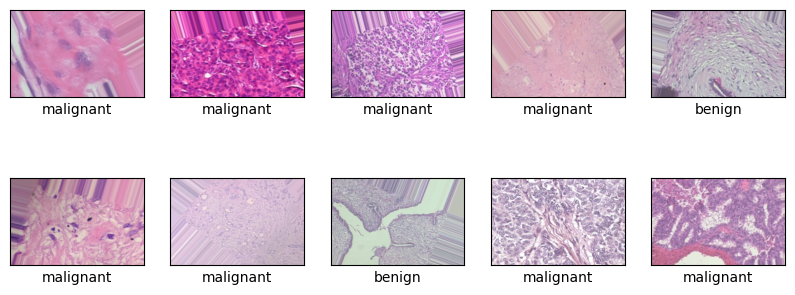

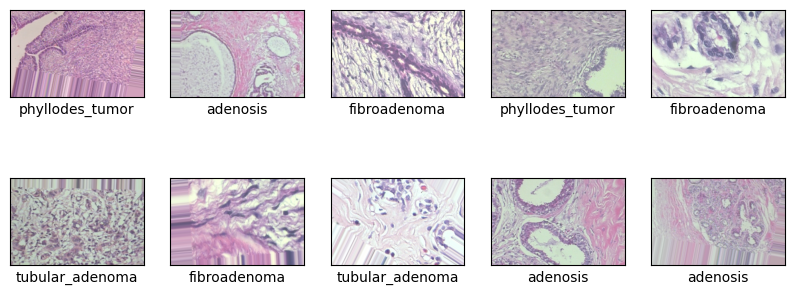

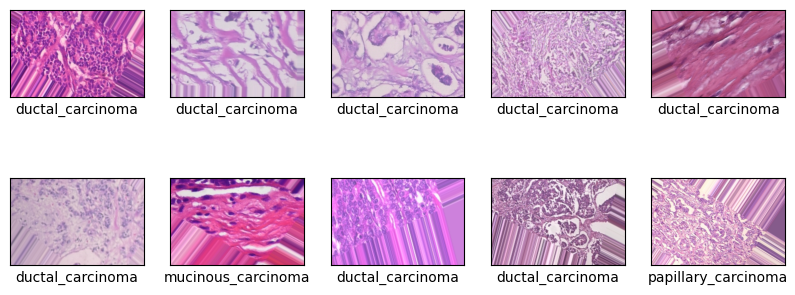

In [29]:
n_images = 10
for i, key in enumerate(keys):
	print("\n")
	random_indices = [random.randint(0, len(augmented_dataset[key]["x_train"])) for _ in range(n_images)]
	images = augmented_dataset[key]["x_train"][random_indices, :, :, :]
	images_labels = augmented_dataset[key]["y_train"][random_indices]
	plt.figure(figsize=(10, 4))
	for j in range(n_images):
		plt.subplot(2, 5, j + 1)
		plot_image(images[j], encoders[i].inverse_transform(np.array([np.argmax(images_labels[j])]))[0])
		plt.xticks([])
		plt.yticks([])
	plt.show()

# Deep Models

In [30]:
deep_models = ["breastnet", "vgg16", "vgg19", "inception-resnet"]
deep_models_results = {}
for i in range(len(keys)):
    deep_models_results[keys[i]] = {}
    deep_models_results[keys[i]]["y_true"] = y_tests[i]
    for deep_model in deep_models:
        deep_models_results[keys[i]][deep_model] = {}

In [31]:
from tensorflow.keras.optimizers.legacy import SGD

In [32]:
loss_functions = ["binary_crossentropy", "categorical_crossentropy", "categorical_crossentropy"]
# batch_size = 64
batch_size = 32
# epochs = 50
epochs = 25
# epochs = 1
# validation_split = 0.1
validation_split = 0.3
train_split = (1 - validation_split)
steps_per_epoch, optimizers = [], []
for i in range(len(keys)):
    steps_per_epoch.append((len(augmented_dataset[keys[i]]["x_train"]) * train_split) / batch_size)
    learning_rate_scheduler = PolynomialDecay(
#         initial_learning_rate=0.01,
        initial_learning_rate=0.001,
        decay_steps=epochs*steps_per_epoch[i],
        end_learning_rate=0.001
    )
    optimizers.append(SGD(learning_rate=learning_rate_scheduler, momentum=0.9, name="SGD"))

In [33]:
breastnet.BreastNet(image_size, n_classes=n_classes[0]).summary()

2023-04-28 20:36:44.627617: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 168, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 168, 256, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 168, 256, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

                                                                  'batch_normalization_4[0][0]']  
                                                                                                  
 leaky_re_lu_1 (LeakyReLU)      (None, 84, 128, 64)  0           ['add_1[0][0]']                  
                                                                                                  
 max_pooling2d_1 (MaxPooling2D)  (None, 42, 64, 64)  0           ['leaky_re_lu_1[0][0]']          
                                                                                                  
 conv2d_6 (Conv2D)              (None, 42, 64, 128)  73856       ['max_pooling2d_1[0][0]']        
                                                                                                  
 batch_normalization_5 (BatchNo  (None, 42, 64, 128)  512        ['conv2d_6[0][0]']               
 rmalization)                                                                                     
          

 obalAveragePooling2D)                                                                            
                                                                                                  
 dense_4 (Dense)                (None, 256)          57600       ['global_average_pooling2d_2[0][0
                                                                 ]']                              
                                                                                                  
 batch_normalization_8 (BatchNo  (None, 256)         1024        ['dense_4[0][0]']                
 rmalization)                                                                                     
                                                                                                  
 activation_6 (Activation)      (None, 256)          0           ['batch_normalization_8[0][0]']  
                                                                                                  
 dropout (

In [34]:


model_name = deep_models[0]
print()
for i in range(len(keys)):
    model = breastnet.BreastNet(image_size, n_classes=n_classes[i])
    model.compile(loss=loss_functions[i], optimizer=optimizers[i], metrics=["accuracy"])
    print("Training " + keys[i] + " " + model_name + "...\n")
    model.fit(
        augmented_dataset[keys[i]]["x_train"],
        augmented_dataset[keys[i]]["y_train"],
        steps_per_epoch=steps_per_epoch[i],
        epochs=epochs,
        batch_size=batch_size,
        validation_split=validation_split
    )
    model.save("./models/" + keys[i] + "_" + model_name)
    print("\n\n")
    # model = load_model("./models/" + keys[i] + "_" + model_name)
    deep_models_results[keys[i]][model_name]["predictions"] = model.predict(x_tests[i])
    deep_models_results[keys[i]][model_name]["y_predicted"] = [
        np.argmax(array) for array in deep_models_results[keys[i]][model_name]["predictions"]
    ]
    report = classification_report(
        deep_models_results[keys[i]]["y_true"],
        deep_models_results[keys[i]][model_name]["y_predicted"],
        output_dict=True
    )
    accuracy, recalls, precisions = compute_stats(report, n_classes[i])
    deep_models_results[keys[i]][model_name]["accuracy"] = accuracy
    deep_models_results[keys[i]][model_name]["recalls"] = recalls
    deep_models_results[keys[i]][model_name]["precisions"] = precisions


Training binary breastnet...

Epoch 1/25
726/726 [==============================] - 4236s 6s/step - loss: 0.3351 - accuracy: 0.8562 - val_loss: 0.8442 - val_accuracy: 0.6996
Epoch 2/25
726/726 [==============================] - 4260s 6s/step - loss: 0.2424 - accuracy: 0.9008 - val_loss: 0.3715 - val_accuracy: 0.8461
Epoch 3/25
726/726 [==============================] - 4269s 6s/step - loss: 0.2068 - accuracy: 0.9133 - val_loss: 0.3194 - val_accuracy: 0.8710
Epoch 4/25
726/726 [==============================] - 4277s 6s/step - loss: 0.1816 - accuracy: 0.9263 - val_loss: 0.2266 - val_accuracy: 0.9057
Epoch 5/25
726/726 [==============================] - 4276s 6s/step - loss: 0.1683 - accuracy: 0.9322 - val_loss: 0.3797 - val_accuracy: 0.8383
Epoch 6/25
726/726 [==============================] - 4277s 6s/step - loss: 0.1468 - accuracy: 0.9394 - val_loss: 0.2920 - val_accuracy: 0.8769
Epoch 7/25
726/726 [==============================] - 4282s 6s/step - loss: 0.1366 - accuracy: 0.9463 - v

INFO:tensorflow:Assets written to: ./models/binary_breastnet/assets


INFO:tensorflow:Assets written to: ./models/binary_breastnet/assets





75/75 [==============================] - 129s 2s/step
Training benign breastnet...

Epoch 1/25
227/227 [==============================] - 1313s 6s/step - loss: 0.9568 - accuracy: 0.5983 - val_loss: 1.8580 - val_accuracy: 0.1763
Epoch 2/25
227/227 [==============================] - 1320s 6s/step - loss: 0.6856 - accuracy: 0.7176 - val_loss: 1.7309 - val_accuracy: 0.4272
Epoch 3/25
227/227 [==============================] - 1316s 6s/step - loss: 0.5697 - accuracy: 0.7656 - val_loss: 3.7176 - val_accuracy: 0.3309
Epoch 4/25
227/227 [==============================] - 1314s 6s/step - loss: 0.4913 - accuracy: 0.7982 - val_loss: 1.3612 - val_accuracy: 0.4957
Epoch 5/25
227/227 [==============================] - 1309s 6s/step - loss: 0.4347 - accuracy: 0.8246 - val_loss: 1.1556 - val_accuracy: 0.5590
Epoch 6/25
227/227 [==============================] - 1310s 6s/step - loss: 0.3801 - accuracy: 0.8473 - val_loss: 1.5937 - val_accuracy: 0.5146
Epoch 7/25
227/227 [=============================

INFO:tensorflow:Assets written to: ./models/benign_breastnet/assets


INFO:tensorflow:Assets written to: ./models/benign_breastnet/assets





24/24 [==============================] - 41s 2s/step
Training malignant breastnet...

Epoch 1/25
498/498 [==============================] - 2844s 6s/step - loss: 0.7414 - accuracy: 0.7018 - val_loss: 0.9113 - val_accuracy: 0.6460
Epoch 2/25
498/498 [==============================] - 2867s 6s/step - loss: 0.5551 - accuracy: 0.7747 - val_loss: 0.9482 - val_accuracy: 0.6692
Epoch 3/25
498/498 [==============================] - 2851s 6s/step - loss: 0.4842 - accuracy: 0.8022 - val_loss: 0.7534 - val_accuracy: 0.7236
Epoch 4/25
498/498 [==============================] - 2860s 6s/step - loss: 0.4431 - accuracy: 0.8197 - val_loss: 0.6778 - val_accuracy: 0.7455
Epoch 5/25
498/498 [==============================] - 2859s 6s/step - loss: 0.3980 - accuracy: 0.8365 - val_loss: 0.5289 - val_accuracy: 0.8081
Epoch 6/25
498/498 [==============================] - 2864s 6s/step - loss: 0.3700 - accuracy: 0.8514 - val_loss: 1.8564 - val_accuracy: 0.3662
Epoch 7/25
498/498 [===========================

INFO:tensorflow:Assets written to: ./models/malignant_breastnet/assets


INFO:tensorflow:Assets written to: ./models/malignant_breastnet/assets





51/51 [==============================] - 88s 2s/step



Binary model's accuracy: 0.8137378845343447



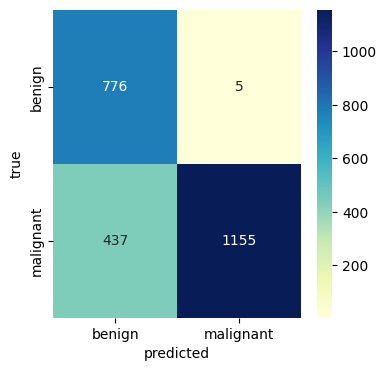




Benign model's accuracy: 0.7728494623655914



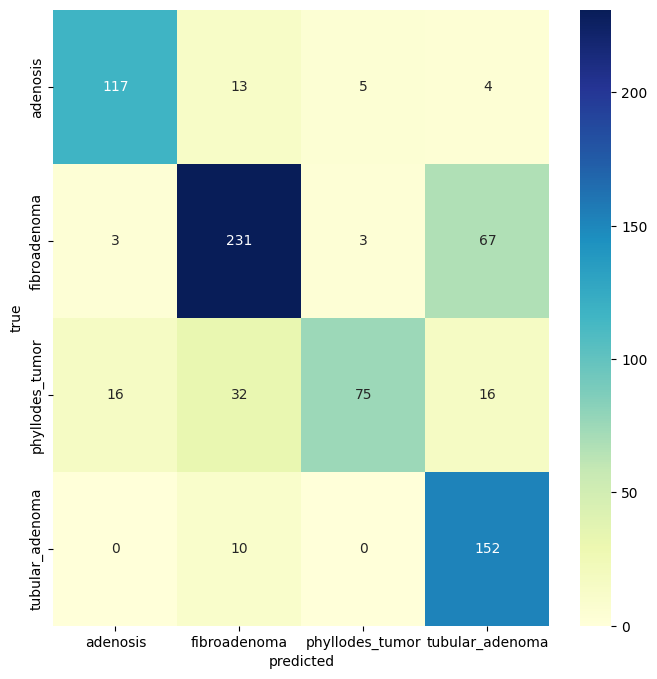




Malignant model's accuracy: 0.8606507059545734



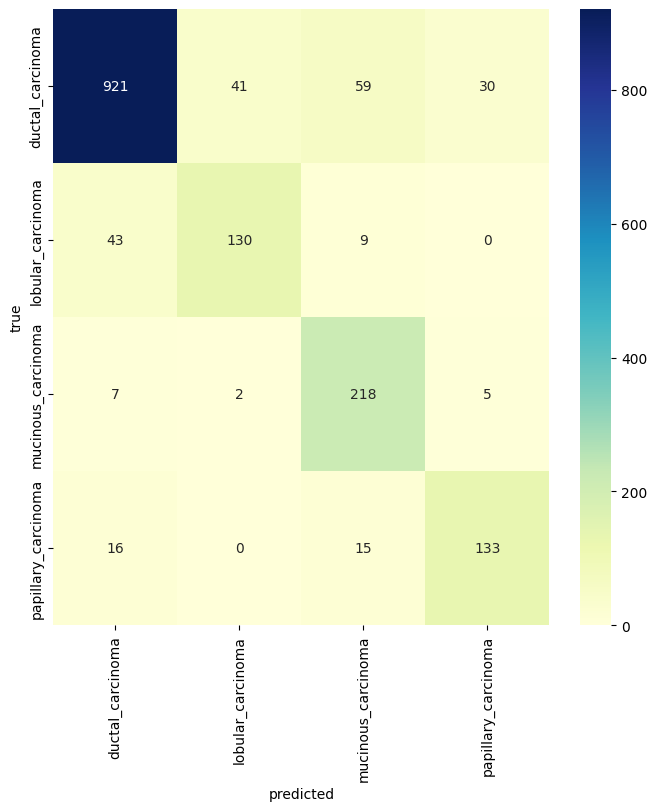

In [35]:
print()
for i in range(len(keys)):
    print(
        keys[i].capitalize() + " model's accuracy: " + str(deep_models_results[keys[i]][model_name]["accuracy"]),
        end="\n\n"
    )
    plot_confusion_matrix(
        deep_models_results[keys[i]]["y_true"],
        deep_models_results[keys[i]][model_name]["y_predicted"],
        labels[i]
    )
    print("\n\n")

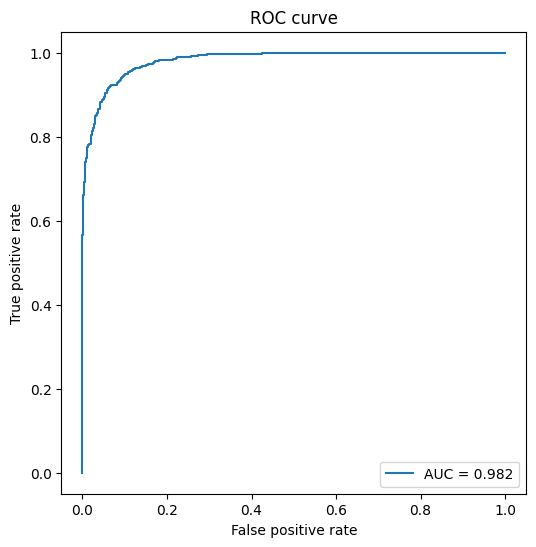

In [36]:
plot_roc_curve(
    deep_models_results["binary"]["y_true"],
    [np.max(array) for array in deep_models_results["binary"][model_name]["predictions"][:, 1]]
)

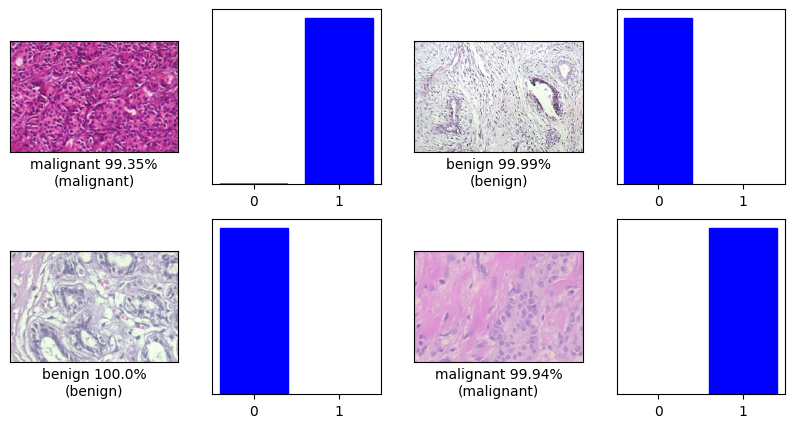

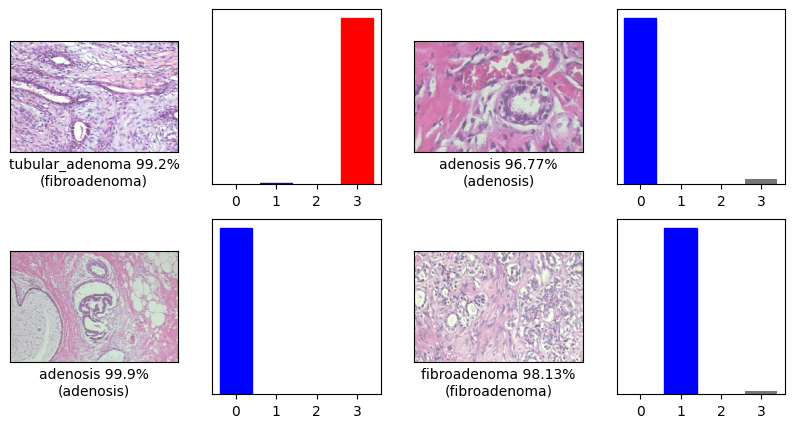

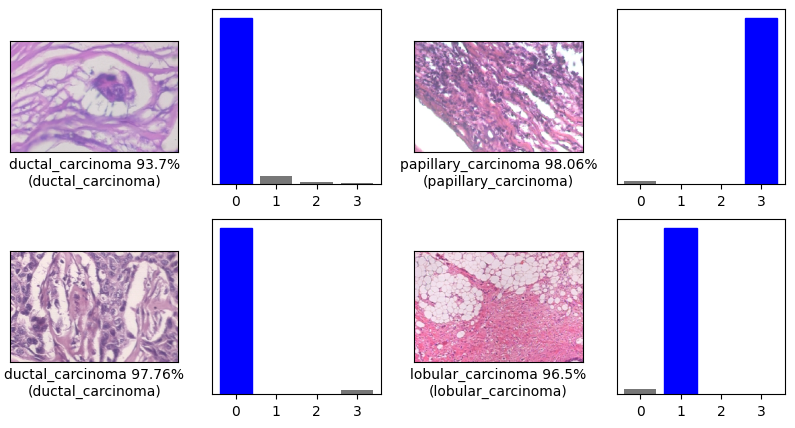

In [37]:

for i in range(len(keys)):
    plot_results(
        [random.randint(0, len(x_tests[i])) for _ in range(16)],
        x_tests[i],
        y_tests_categorical[i],
        deep_models_results[keys[i]][model_name]["predictions"],
        encoders[i]
    )

# VGG16

In [38]:
VGG16(
    include_top=True,
    weights=None,
    input_tensor=None,
    input_shape=image_size,
    pooling='max',
    classes=n_classes[0],
    classifier_activation='softmax'
).summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 168, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 168, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 168, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 84, 128, 64)       0         
                                                                 
 block2_conv1 (Conv2D)       (None, 84, 128, 128)      73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 84, 128, 128)      147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 42, 64, 128)       0     

In [39]:
model_name = deep_models[1]
print()
for i in range(len(keys)):
    model = VGG16(
        include_top=True,
        weights=None,
        input_tensor=None,
        input_shape=image_size,
        pooling='max',
        classes=n_classes[i],
        classifier_activation='softmax'
    )
    model.compile(loss=loss_functions[i], optimizer=optimizers[i], metrics=["accuracy"])
    print("Training " + keys[i] + " " + model_name + "...\n")
    model.fit(
        augmented_dataset[keys[i]]["x_train"],
        augmented_dataset[keys[i]]["y_train"],
        steps_per_epoch=steps_per_epoch[i],
        epochs=epochs,
        batch_size=batch_size,
        validation_split=validation_split
    )
    model.save("./models/" + keys[i] + "_" + model_name)
    print("\n\n")
    # model = load_model("./models/" + keys[i] + "_" + model_name)
    deep_models_results[keys[i]][model_name]["predictions"] = model.predict(x_tests[i])
    deep_models_results[keys[i]][model_name]["y_predicted"] = [
        np.argmax(array) for array in deep_models_results[keys[i]][model_name]["predictions"]
    ]
    report = classification_report(
        deep_models_results[keys[i]]["y_true"],
        deep_models_results[keys[i]][model_name]["y_predicted"],
        output_dict=True
    )
    accuracy, recalls, precisions = compute_stats(report, n_classes[i])
    deep_models_results[keys[i]][model_name]["accuracy"] = accuracy
    deep_models_results[keys[i]][model_name]["recalls"] = recalls
    deep_models_results[keys[i]][model_name]["precisions"] = precisions



Training binary vgg16...

Epoch 1/25
726/726 [==============================] - 5240s 7s/step - loss: 0.6049 - accuracy: 0.6927 - val_loss: 0.5012 - val_accuracy: 0.6932
Epoch 2/25
726/726 [==============================] - 5217s 7s/step - loss: 0.4920 - accuracy: 0.7764 - val_loss: 0.4397 - val_accuracy: 0.8264
Epoch 3/25
726/726 [==============================] - 5219s 7s/step - loss: 0.4470 - accuracy: 0.8219 - val_loss: 0.4917 - val_accuracy: 0.7933
Epoch 4/25
726/726 [==============================] - 5237s 7s/step - loss: 0.4220 - accuracy: 0.8329 - val_loss: 0.3916 - val_accuracy: 0.8514
Epoch 5/25
726/726 [==============================] - 5260s 7s/step - loss: 0.4129 - accuracy: 0.8375 - val_loss: 0.3947 - val_accuracy: 0.8456
Epoch 6/25
726/726 [==============================] - 5246s 7s/step - loss: 0.4018 - accuracy: 0.8432 - val_loss: 0.6073 - val_accuracy: 0.6445
Epoch 7/25
726/726 [==============================] - 5281s 7s/step - loss: 0.3971 - accuracy: 0.8455 - val_l

INFO:tensorflow:Assets written to: ./models/binary_vgg16/assets


INFO:tensorflow:Assets written to: ./models/binary_vgg16/assets





75/75 [==============================] - 126s 2s/step
Training benign vgg16...

Epoch 1/25
227/227 [==============================] - 1653s 7s/step - loss: 1.3354 - accuracy: 0.4084 - val_loss: 1.3189 - val_accuracy: 0.4102
Epoch 2/25
227/227 [==============================] - 1660s 7s/step - loss: 1.3200 - accuracy: 0.4084 - val_loss: 1.3184 - val_accuracy: 0.4102
Epoch 3/25
227/227 [==============================] - 1646s 7s/step - loss: 1.3193 - accuracy: 0.4084 - val_loss: 1.3184 - val_accuracy: 0.4102
Epoch 4/25
227/227 [==============================] - 1633s 7s/step - loss: 1.3186 - accuracy: 0.4084 - val_loss: 1.3165 - val_accuracy: 0.4102
Epoch 5/25
227/227 [==============================] - 1641s 7s/step - loss: 1.3157 - accuracy: 0.4084 - val_loss: 1.3103 - val_accuracy: 0.4102
Epoch 6/25
227/227 [==============================] - 1649s 7s/step - loss: 1.2953 - accuracy: 0.4084 - val_loss: 1.2450 - val_accuracy: 0.4102
Epoch 7/25
227/227 [==============================] -

INFO:tensorflow:Assets written to: ./models/benign_vgg16/assets


INFO:tensorflow:Assets written to: ./models/benign_vgg16/assets





24/24 [==============================] - 38s 2s/step
Training malignant vgg16...

Epoch 1/25
498/498 [==============================] - 3578s 7s/step - loss: 1.0892 - accuracy: 0.6288 - val_loss: 1.0512 - val_accuracy: 0.6343
Epoch 2/25
498/498 [==============================] - 3581s 7s/step - loss: 1.0373 - accuracy: 0.6304 - val_loss: 0.9927 - val_accuracy: 0.6343
Epoch 3/25
498/498 [==============================] - 3593s 7s/step - loss: 0.9995 - accuracy: 0.6304 - val_loss: 0.9682 - val_accuracy: 0.6343
Epoch 4/25
498/498 [==============================] - 3572s 7s/step - loss: 0.9852 - accuracy: 0.6304 - val_loss: 0.9780 - val_accuracy: 0.6343
Epoch 5/25
498/498 [==============================] - 3568s 7s/step - loss: 0.9783 - accuracy: 0.6304 - val_loss: 0.9621 - val_accuracy: 0.6343
Epoch 6/25
498/498 [==============================] - 3563s 7s/step - loss: 0.9734 - accuracy: 0.6304 - val_loss: 0.9543 - val_accuracy: 0.6343
Epoch 7/25
498/498 [==============================]

INFO:tensorflow:Assets written to: ./models/malignant_vgg16/assets


INFO:tensorflow:Assets written to: ./models/malignant_vgg16/assets





51/51 [==============================] - 84s 2s/step


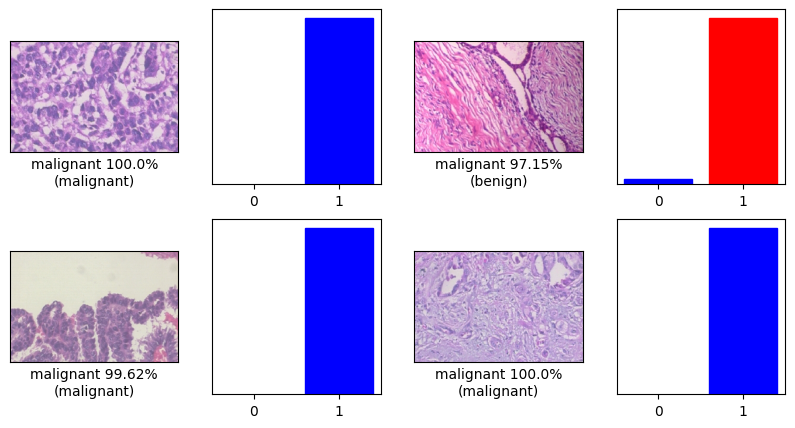

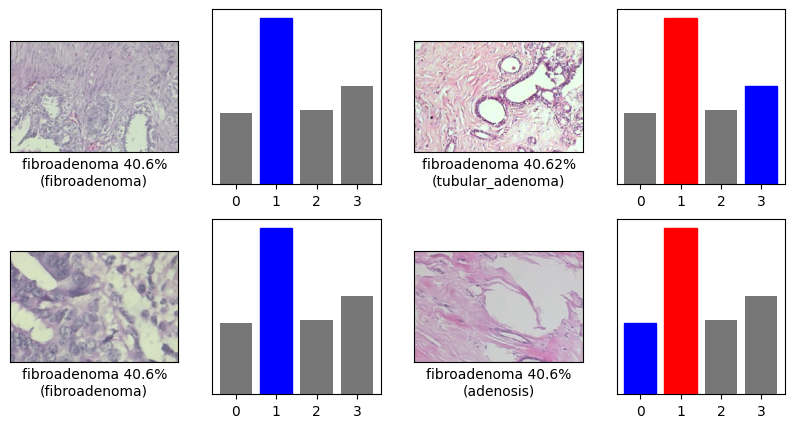

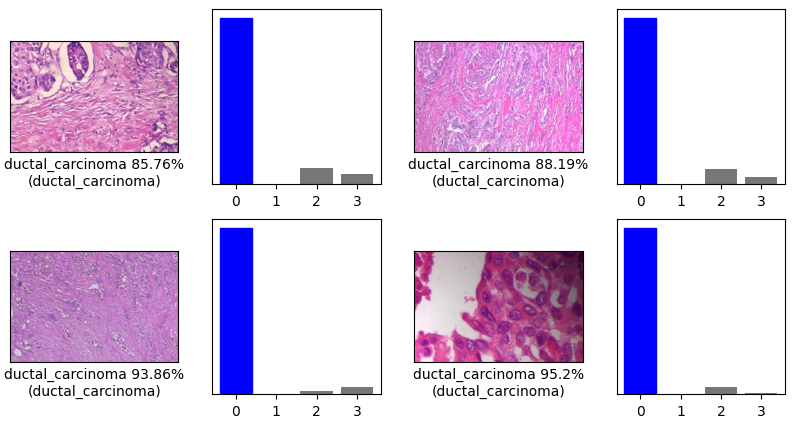

In [71]:
model_name = deep_models[1]
for i in range(len(keys)):
    plot_results(
        [random.randint(0, len(x_tests[i])) for _ in range(16)],
        x_tests[i],
        y_tests_categorical[i],
        deep_models_results[keys[i]][model_name]["predictions"],
        encoders[i]
    )


Binary model's accuracy: 0.9085545722713865



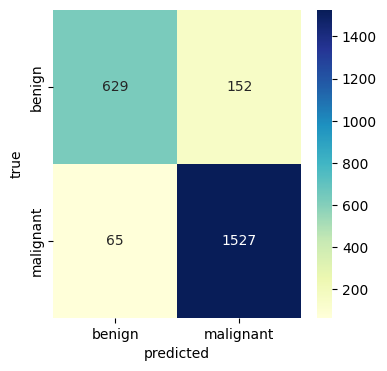




Benign model's accuracy: 0.40860215053763443



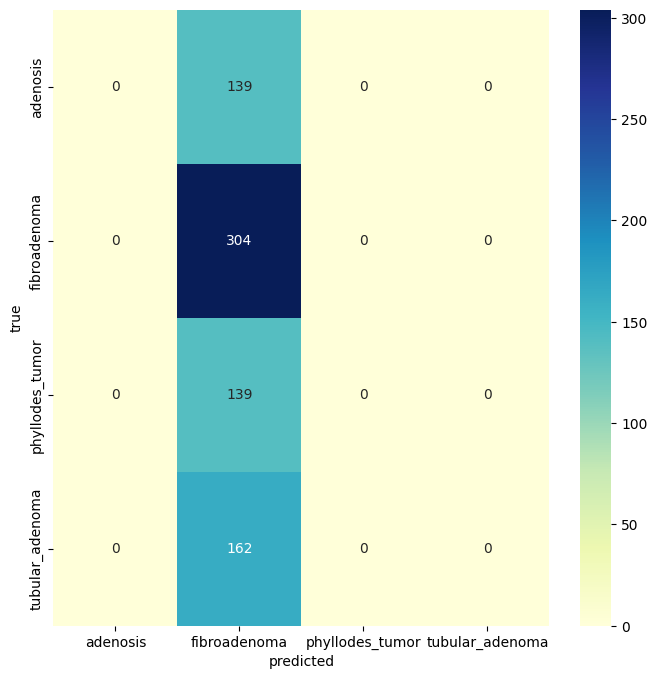




Malignant model's accuracy: 0.7176181706568447



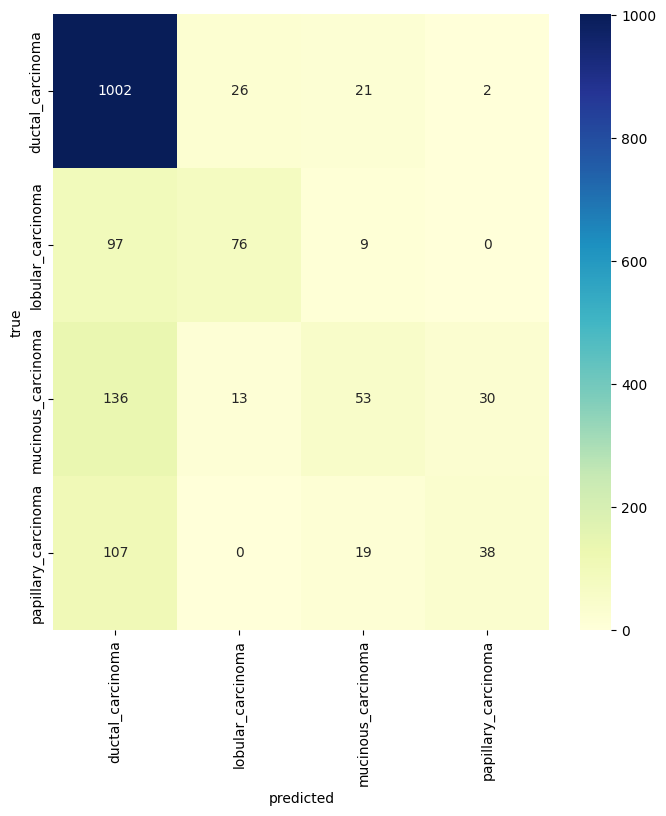

In [72]:
model_name = deep_models[1]
print()
for i in range(len(keys)):
    print(
        keys[i].capitalize() + " model's accuracy: " + str(deep_models_results[keys[i]][model_name]["accuracy"]),
        end="\n\n"
    )
    plot_confusion_matrix(
        deep_models_results[keys[i]]["y_true"],
        deep_models_results[keys[i]][model_name]["y_predicted"],
        labels[i]
    )
    print("\n\n")

# VGG19

In [40]:
VGG19(
    include_top=True,
    weights=None,
    input_tensor=None,
    input_shape=image_size,
    pooling='max',
    classes=n_classes[0],
    classifier_activation='softmax'
).summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 168, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 168, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 168, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 84, 128, 64)       0         
                                                                 
 block2_conv1 (Conv2D)       (None, 84, 128, 128)      73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 84, 128, 128)      147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 42, 64, 128)       0     

In [41]:
model_name = deep_models[2]
print()
for i in range(len(keys)):
    model = VGG19(
        include_top=True,
        weights=None,
        input_tensor=None,
        input_shape=image_size,
        pooling='max',
        classes=n_classes[i],
        classifier_activation='softmax'
    )
    model.compile(loss=loss_functions[i], optimizer=optimizers[i], metrics=["accuracy"])
    print("Training " + keys[i] + " " + model_name + "...\n")
    model.fit(
        augmented_dataset[keys[i]]["x_train"],
        augmented_dataset[keys[i]]["y_train"],
        steps_per_epoch=steps_per_epoch[i],
        epochs=epochs,
        batch_size=batch_size,
        validation_split=validation_split
    )
    model.save("./models/" + keys[i] + "_" + model_name)
    print("\n\n")
    # model = load_model("./models/" + keys[i] + "_" + model_name)
    deep_models_results[keys[i]][model_name]["predictions"] = model.predict(x_tests[i])
    deep_models_results[keys[i]][model_name]["y_predicted"] = [
        np.argmax(array) for array in deep_models_results[keys[i]][model_name]["predictions"]
    ]
    report = classification_report(
        deep_models_results[keys[i]]["y_true"],
        deep_models_results[keys[i]][model_name]["y_predicted"],
        output_dict=True
    )
    accuracy, recalls, precisions = compute_stats(report, n_classes[i])
    deep_models_results[keys[i]][model_name]["accuracy"] = accuracy
    deep_models_results[keys[i]][model_name]["recalls"] = recalls
    deep_models_results[keys[i]][model_name]["precisions"] = precisions
     


Training binary vgg19...

Epoch 1/25
726/726 [==============================] - 6324s 9s/step - loss: 0.6286 - accuracy: 0.6922 - val_loss: 0.6155 - val_accuracy: 0.6932
Epoch 2/25
726/726 [==============================] - 6296s 9s/step - loss: 0.5738 - accuracy: 0.6930 - val_loss: 0.5192 - val_accuracy: 0.6932
Epoch 3/25
726/726 [==============================] - 6277s 9s/step - loss: 0.4879 - accuracy: 0.7828 - val_loss: 0.4516 - val_accuracy: 0.8266
Epoch 4/25
726/726 [==============================] - 6278s 9s/step - loss: 0.4490 - accuracy: 0.8177 - val_loss: 0.4142 - val_accuracy: 0.8427
Epoch 5/25
726/726 [==============================] - 6285s 9s/step - loss: 0.4327 - accuracy: 0.8278 - val_loss: 0.4058 - val_accuracy: 0.8430
Epoch 6/25
726/726 [==============================] - 6291s 9s/step - loss: 0.4231 - accuracy: 0.8337 - val_loss: 0.4976 - val_accuracy: 0.7708
Epoch 7/25
726/726 [==============================] - 6304s 9s/step - loss: 0.4047 - accuracy: 0.8446 - val_l

INFO:tensorflow:Assets written to: ./models/binary_vgg19/assets


INFO:tensorflow:Assets written to: ./models/binary_vgg19/assets





75/75 [==============================] - 151s 2s/step
Training benign vgg19...

Epoch 1/25
227/227 [==============================] - 1943s 9s/step - loss: 1.3385 - accuracy: 0.4080 - val_loss: 1.3202 - val_accuracy: 0.4102
Epoch 2/25
227/227 [==============================] - 1956s 9s/step - loss: 1.3211 - accuracy: 0.4084 - val_loss: 1.3200 - val_accuracy: 0.4102
Epoch 3/25
227/227 [==============================] - 1943s 9s/step - loss: 1.3209 - accuracy: 0.4084 - val_loss: 1.3200 - val_accuracy: 0.4102
Epoch 4/25
227/227 [==============================] - 1946s 9s/step - loss: 1.3208 - accuracy: 0.4084 - val_loss: 1.3195 - val_accuracy: 0.4102
Epoch 5/25
227/227 [==============================] - 1946s 9s/step - loss: 1.3203 - accuracy: 0.4084 - val_loss: 1.3195 - val_accuracy: 0.4102
Epoch 6/25
227/227 [==============================] - 1948s 9s/step - loss: 1.3199 - accuracy: 0.4084 - val_loss: 1.3186 - val_accuracy: 0.4102
Epoch 7/25
227/227 [==============================] -

INFO:tensorflow:Assets written to: ./models/benign_vgg19/assets


INFO:tensorflow:Assets written to: ./models/benign_vgg19/assets





24/24 [==============================] - 55s 2s/step
Training malignant vgg19...

Epoch 1/25
498/498 [==============================] - 4905s 10s/step - loss: 1.0893 - accuracy: 0.6297 - val_loss: 1.0535 - val_accuracy: 0.6343
Epoch 2/25
498/498 [==============================] - 4861s 10s/step - loss: 1.0565 - accuracy: 0.6304 - val_loss: 1.0565 - val_accuracy: 0.6343
Epoch 3/25
498/498 [==============================] - 4851s 10s/step - loss: 1.0519 - accuracy: 0.6304 - val_loss: 1.0333 - val_accuracy: 0.6343
Epoch 4/25
498/498 [==============================] - 4855s 10s/step - loss: 1.0179 - accuracy: 0.6304 - val_loss: 0.9952 - val_accuracy: 0.6343
Epoch 5/25
498/498 [==============================] - 4832s 10s/step - loss: 1.0044 - accuracy: 0.6304 - val_loss: 0.9783 - val_accuracy: 0.6343
Epoch 6/25
498/498 [==============================] - 4758s 10s/step - loss: 0.9909 - accuracy: 0.6304 - val_loss: 0.9646 - val_accuracy: 0.6343
Epoch 7/25
498/498 [=========================

INFO:tensorflow:Assets written to: ./models/malignant_vgg19/assets


INFO:tensorflow:Assets written to: ./models/malignant_vgg19/assets





51/51 [==============================] - 113s 2s/step


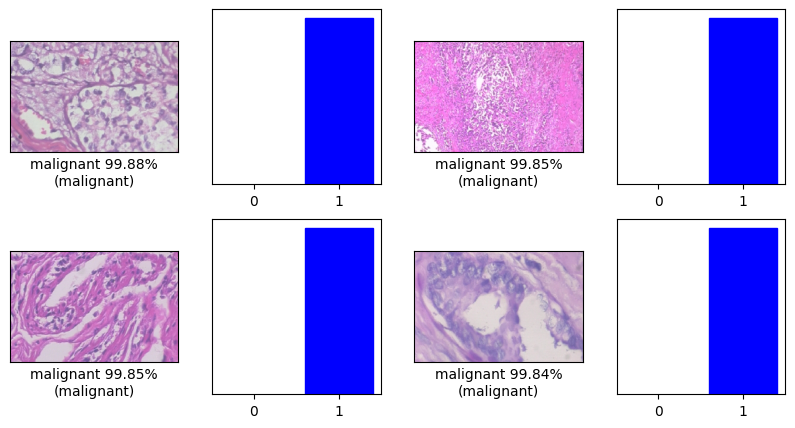

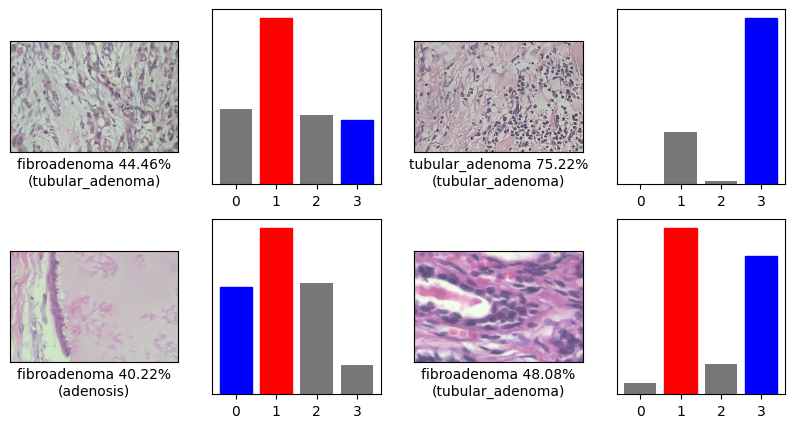

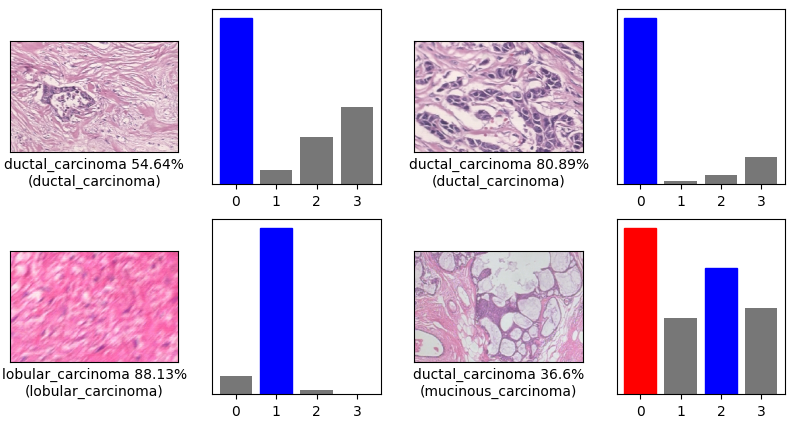

In [70]:
model_name = deep_models[2]
for i in range(len(keys)):
    plot_results(
        [random.randint(0, len(x_tests[i])) for _ in range(16)],
        x_tests[i],
        y_tests_categorical[i],
        deep_models_results[keys[i]][model_name]["predictions"],
        encoders[i]
    )


Binary model's accuracy: 0.8702064896755162



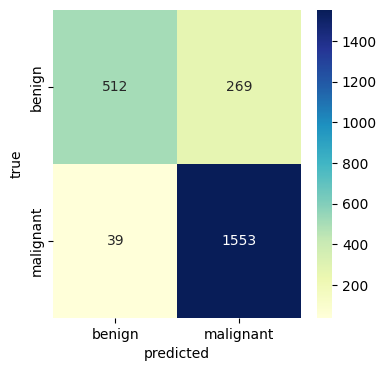




Benign model's accuracy: 0.46102150537634407



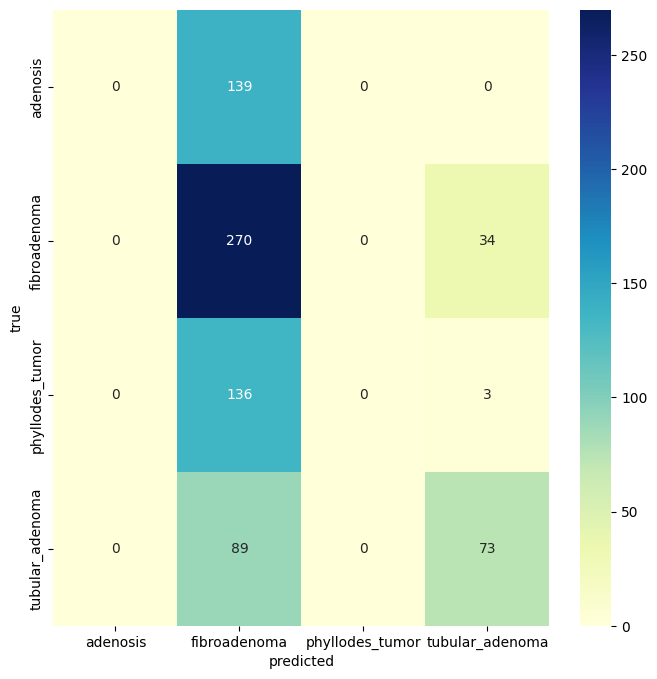




Malignant model's accuracy: 0.6955187231430325



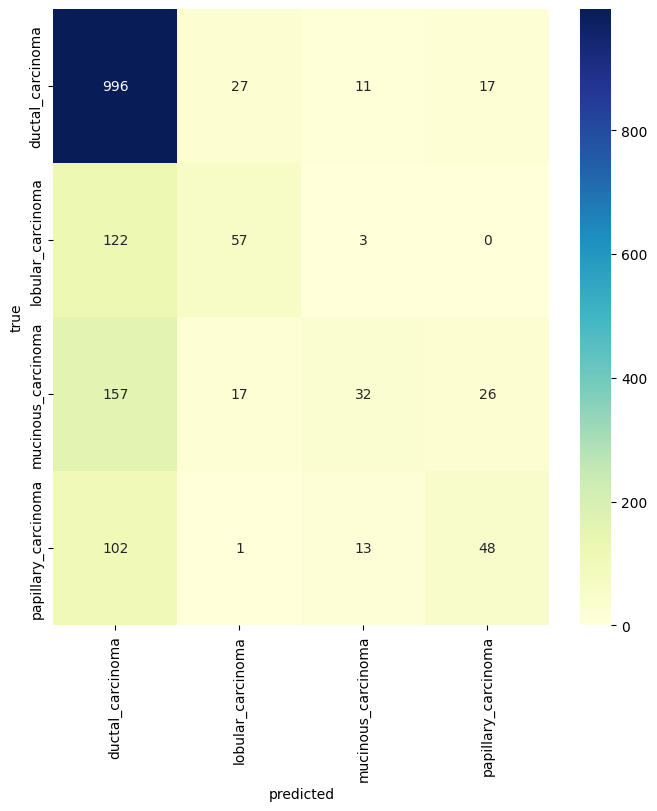

In [73]:
model_name = deep_models[2]
print()
for i in range(len(keys)):
    print(
        keys[i].capitalize() + " model's accuracy: " + str(deep_models_results[keys[i]][model_name]["accuracy"]),
        end="\n\n"
    )
    plot_confusion_matrix(
        deep_models_results[keys[i]]["y_true"],
        deep_models_results[keys[i]][model_name]["y_predicted"],
        labels[i]
    )
    print("\n\n")

# Inception ResNet

In [42]:
InceptionResNetV2(
    include_top=True,
    weights=None,
    input_tensor=None,
    input_shape=image_size,
    pooling='max',
    classes=n_classes[0],
    classifier_activation='softmax'
).summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 168, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_40 (Conv2D)             (None, 83, 127, 32)  864         ['input_13[0][0]']               
                                                                                                  
 batch_normalization_40 (BatchN  (None, 83, 127, 32)  96         ['conv2d_40[0][0]']              
 ormalization)                                                                                    
                                                                                

 ormalization)                                                                                    
                                                                                                  
 batch_normalization_50 (BatchN  (None, 18, 29, 96)  288         ['conv2d_50[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_51 (BatchN  (None, 18, 29, 64)  192         ['conv2d_51[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_37 (Activation)     (None, 18, 29, 96)   0           ['batch_normalization_45[0][0]'] 
                                                                                                  
 activatio

 conv2d_62 (Conv2D)             (None, 18, 29, 48)   13824       ['activation_53[0][0]']          
                                                                                                  
 batch_normalization_59 (BatchN  (None, 18, 29, 32)  96          ['conv2d_59[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_62 (BatchN  (None, 18, 29, 48)  144         ['conv2d_62[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_51 (Activation)     (None, 18, 29, 32)   0           ['batch_normalization_59[0][0]'] 
                                                                                                  
 activatio

                                                                                                  
 activation_61 (Activation)     (None, 18, 29, 64)   0           ['batch_normalization_69[0][0]'] 
                                                                                                  
 block35_3_mixed (Concatenate)  (None, 18, 29, 128)  0           ['activation_56[0][0]',          
                                                                  'activation_58[0][0]',          
                                                                  'activation_61[0][0]']          
                                                                                                  
 block35_3_conv (Conv2D)        (None, 18, 29, 320)  41280       ['block35_3_mixed[0][0]']        
                                                                                                  
 block35_3 (Lambda)             (None, 18, 29, 320)  0           ['block35_2_ac[0][0]',           
          

                                                                                                  
 activation_69 (Activation)     (None, 18, 29, 32)   0           ['batch_normalization_77[0][0]'] 
                                                                                                  
 activation_72 (Activation)     (None, 18, 29, 48)   0           ['batch_normalization_80[0][0]'] 
                                                                                                  
 conv2d_76 (Conv2D)             (None, 18, 29, 32)   10240       ['block35_4_ac[0][0]']           
                                                                                                  
 conv2d_78 (Conv2D)             (None, 18, 29, 32)   9216        ['activation_69[0][0]']          
                                                                                                  
 conv2d_81 (Conv2D)             (None, 18, 29, 64)   27648       ['activation_72[0][0]']          
          

 block35_6_conv (Conv2D)        (None, 18, 29, 320)  41280       ['block35_6_mixed[0][0]']        
                                                                                                  
 block35_6 (Lambda)             (None, 18, 29, 320)  0           ['block35_5_ac[0][0]',           
                                                                  'block35_6_conv[0][0]']         
                                                                                                  
 block35_6_ac (Activation)      (None, 18, 29, 320)  0           ['block35_6[0][0]']              
                                                                                                  
 conv2d_91 (Conv2D)             (None, 18, 29, 32)   10240       ['block35_6_ac[0][0]']           
                                                                                                  
 batch_normalization_91 (BatchN  (None, 18, 29, 32)  96          ['conv2d_91[0][0]']              
 ormalizat

 conv2d_96 (Conv2D)             (None, 18, 29, 32)   9216        ['activation_87[0][0]']          
                                                                                                  
 conv2d_99 (Conv2D)             (None, 18, 29, 64)   27648       ['activation_90[0][0]']          
                                                                                                  
 batch_normalization_94 (BatchN  (None, 18, 29, 32)  96          ['conv2d_94[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_96 (BatchN  (None, 18, 29, 32)  96          ['conv2d_96[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_nor

 conv2d_109 (Conv2D)            (None, 18, 29, 32)   10240       ['block35_9_ac[0][0]']           
                                                                                                  
 batch_normalization_109 (Batch  (None, 18, 29, 32)  96          ['conv2d_109[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_101 (Activation)    (None, 18, 29, 32)   0           ['batch_normalization_109[0][0]']
                                                                                                  
 conv2d_107 (Conv2D)            (None, 18, 29, 32)   10240       ['block35_9_ac[0][0]']           
                                                                                                  
 conv2d_110 (Conv2D)            (None, 18, 29, 48)   13824       ['activation_101[0][0]']         
          

                                                                                                  
 mixed_6a (Concatenate)         (None, 8, 14, 1088)  0           ['activation_104[0][0]',         
                                                                  'activation_107[0][0]',         
                                                                  'max_pooling2d_14[0][0]']       
                                                                                                  
 conv2d_117 (Conv2D)            (None, 8, 14, 128)   139264      ['mixed_6a[0][0]']               
                                                                                                  
 batch_normalization_117 (Batch  (None, 8, 14, 128)  384         ['conv2d_117[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activatio

 batch_normalization_125 (Batch  (None, 8, 14, 128)  384         ['conv2d_125[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_117 (Activation)    (None, 8, 14, 128)   0           ['batch_normalization_125[0][0]']
                                                                                                  
 conv2d_126 (Conv2D)            (None, 8, 14, 160)   143360      ['activation_117[0][0]']         
                                                                                                  
 batch_normalization_126 (Batch  (None, 8, 14, 160)  480         ['conv2d_126[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activatio

 batch_normalization_134 (Batch  (None, 8, 14, 160)  480         ['conv2d_134[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_126 (Activation)    (None, 8, 14, 160)   0           ['batch_normalization_134[0][0]']
                                                                                                  
 conv2d_132 (Conv2D)            (None, 8, 14, 192)   208896      ['block17_4_ac[0][0]']           
                                                                                                  
 conv2d_135 (Conv2D)            (None, 8, 14, 192)   215040      ['activation_126[0][0]']         
                                                                                                  
 batch_normalization_132 (Batch  (None, 8, 14, 192)  576         ['conv2d_132[0][0]']             
 Normaliza

 conv2d_143 (Conv2D)            (None, 8, 14, 192)   215040      ['activation_134[0][0]']         
                                                                                                  
 batch_normalization_140 (Batch  (None, 8, 14, 192)  576         ['conv2d_140[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_143 (Batch  (None, 8, 14, 192)  576         ['conv2d_143[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_132 (Activation)    (None, 8, 14, 192)   0           ['batch_normalization_140[0][0]']
                                                                                                  
 activatio

                                                                                                  
 activation_140 (Activation)    (None, 8, 14, 192)   0           ['batch_normalization_148[0][0]']
                                                                                                  
 activation_143 (Activation)    (None, 8, 14, 192)   0           ['batch_normalization_151[0][0]']
                                                                                                  
 block17_9_mixed (Concatenate)  (None, 8, 14, 384)   0           ['activation_140[0][0]',         
                                                                  'activation_143[0][0]']         
                                                                                                  
 block17_9_conv (Conv2D)        (None, 8, 14, 1088)  418880      ['block17_9_mixed[0][0]']        
                                                                                                  
 block17_9

                                                                                                  
 block17_11_conv (Conv2D)       (None, 8, 14, 1088)  418880      ['block17_11_mixed[0][0]']       
                                                                                                  
 block17_11 (Lambda)            (None, 8, 14, 1088)  0           ['block17_10_ac[0][0]',          
                                                                  'block17_11_conv[0][0]']        
                                                                                                  
 block17_11_ac (Activation)     (None, 8, 14, 1088)  0           ['block17_11[0][0]']             
                                                                                                  
 conv2d_161 (Conv2D)            (None, 8, 14, 128)   139264      ['block17_11_ac[0][0]']          
                                                                                                  
 batch_nor

                                                                                                  
 conv2d_169 (Conv2D)            (None, 8, 14, 128)   139264      ['block17_13_ac[0][0]']          
                                                                                                  
 batch_normalization_169 (Batch  (None, 8, 14, 128)  384         ['conv2d_169[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_161 (Activation)    (None, 8, 14, 128)   0           ['batch_normalization_169[0][0]']
                                                                                                  
 conv2d_170 (Conv2D)            (None, 8, 14, 160)   143360      ['activation_161[0][0]']         
                                                                                                  
 batch_nor

                                                                                                  
 conv2d_178 (Conv2D)            (None, 8, 14, 160)   143360      ['activation_169[0][0]']         
                                                                                                  
 batch_normalization_178 (Batch  (None, 8, 14, 160)  480         ['conv2d_178[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_170 (Activation)    (None, 8, 14, 160)   0           ['batch_normalization_178[0][0]']
                                                                                                  
 conv2d_176 (Conv2D)            (None, 8, 14, 192)   208896      ['block17_15_ac[0][0]']          
                                                                                                  
 conv2d_17

                                                                                                  
 conv2d_184 (Conv2D)            (None, 8, 14, 192)   208896      ['block17_17_ac[0][0]']          
                                                                                                  
 conv2d_187 (Conv2D)            (None, 8, 14, 192)   215040      ['activation_178[0][0]']         
                                                                                                  
 batch_normalization_184 (Batch  (None, 8, 14, 192)  576         ['conv2d_184[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_187 (Batch  (None, 8, 14, 192)  576         ['conv2d_187[0][0]']             
 Normalization)                                                                                   
          

                                                                                                  
 batch_normalization_195 (Batch  (None, 8, 14, 192)  576         ['conv2d_195[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_184 (Activation)    (None, 8, 14, 192)   0           ['batch_normalization_192[0][0]']
                                                                                                  
 activation_187 (Activation)    (None, 8, 14, 192)   0           ['batch_normalization_195[0][0]']
                                                                                                  
 block17_20_mixed (Concatenate)  (None, 8, 14, 384)  0           ['activation_184[0][0]',         
                                                                  'activation_187[0][0]']         
          

                                                                                                  
 batch_normalization_205 (Batch  (None, 3, 6, 224)   672         ['conv2d_205[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_197 (Activation)    (None, 3, 6, 224)    0           ['batch_normalization_205[0][0]']
                                                                                                  
 conv2d_203 (Conv2D)            (None, 3, 6, 192)    399360      ['mixed_7a[0][0]']               
                                                                                                  
 conv2d_206 (Conv2D)            (None, 3, 6, 256)    172032      ['activation_197[0][0]']         
                                                                                                  
 batch_nor

                                                                                                  
 conv2d_214 (Conv2D)            (None, 3, 6, 256)    172032      ['activation_205[0][0]']         
                                                                                                  
 batch_normalization_211 (Batch  (None, 3, 6, 192)   576         ['conv2d_211[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_214 (Batch  (None, 3, 6, 256)   768         ['conv2d_214[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_203 (Activation)    (None, 3, 6, 192)    0           ['batch_normalization_211[0][0]']
          

 Normalization)                                                                                   
                                                                                                  
 activation_211 (Activation)    (None, 3, 6, 192)    0           ['batch_normalization_219[0][0]']
                                                                                                  
 activation_214 (Activation)    (None, 3, 6, 256)    0           ['batch_normalization_222[0][0]']
                                                                                                  
 block8_5_mixed (Concatenate)   (None, 3, 6, 448)    0           ['activation_211[0][0]',         
                                                                  'activation_214[0][0]']         
                                                                                                  
 block8_5_conv (Conv2D)         (None, 3, 6, 2080)   933920      ['block8_5_mixed[0][0]']         
          

                                                                  'activation_222[0][0]']         
                                                                                                  
 block8_7_conv (Conv2D)         (None, 3, 6, 2080)   933920      ['block8_7_mixed[0][0]']         
                                                                                                  
 block8_7 (Lambda)              (None, 3, 6, 2080)   0           ['block8_6_ac[0][0]',            
                                                                  'block8_7_conv[0][0]']          
                                                                                                  
 block8_7_ac (Activation)       (None, 3, 6, 2080)   0           ['block8_7[0][0]']               
                                                                                                  
 conv2d_232 (Conv2D)            (None, 3, 6, 192)    399360      ['block8_7_ac[0][0]']            
          

 block8_9_ac (Activation)       (None, 3, 6, 2080)   0           ['block8_9[0][0]']               
                                                                                                  
 conv2d_240 (Conv2D)            (None, 3, 6, 192)    399360      ['block8_9_ac[0][0]']            
                                                                                                  
 batch_normalization_240 (Batch  (None, 3, 6, 192)   576         ['conv2d_240[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_232 (Activation)    (None, 3, 6, 192)    0           ['batch_normalization_240[0][0]']
                                                                                                  
 conv2d_241 (Conv2D)            (None, 3, 6, 224)    129024      ['activation_232[0][0]']         
          

In [43]:
model_name = deep_models[3]
print()
for i in range(len(keys)):
    model = InceptionResNetV2(
        include_top=True,
        weights=None,
        input_tensor=None,
        input_shape=image_size,
        pooling='max',
        classes=n_classes[i],
        classifier_activation='softmax'
    )
    model.compile(loss=loss_functions[i], optimizer=optimizers[i], metrics=["accuracy"])
    print("Training " + keys[i] + " " + model_name + "...\n")
    model.fit(
        augmented_dataset[keys[i]]["x_train"],
        augmented_dataset[keys[i]]["y_train"],
        steps_per_epoch=steps_per_epoch[i],
        epochs=epochs,
        batch_size=batch_size,
        validation_split=validation_split
    )
    model.save("./models/" + keys[i] + "_" + model_name)
    print("\n\n")
    # model = load_model("./models/" + keys[i] + "_" + model_name) 
    deep_models_results[keys[i]][model_name]["predictions"] = model.predict(x_tests[i])
    deep_models_results[keys[i]][model_name]["y_predicted"] = [
        np.argmax(array) for array in deep_models_results[keys[i]][model_name]["predictions"]
    ]
    report = classification_report(
        deep_models_results[keys[i]]["y_true"],
        deep_models_results[keys[i]][model_name]["y_predicted"],
        output_dict=True
    )
    accuracy, recalls, precisions = compute_stats(report, n_classes[i])
    deep_models_results[keys[i]][model_name]["accuracy"] = accuracy
    deep_models_results[keys[i]][model_name]["recalls"] = recalls
    deep_models_results[keys[i]][model_name]["precisions"] = precisions


Training binary inception-resnet...

Epoch 1/25
726/726 [==============================] - 3602s 5s/step - loss: 0.3174 - accuracy: 0.8610 - val_loss: 0.4129 - val_accuracy: 0.8253
Epoch 2/25
726/726 [==============================] - 3592s 5s/step - loss: 0.2290 - accuracy: 0.9025 - val_loss: 0.4461 - val_accuracy: 0.8541
Epoch 3/25
726/726 [==============================] - 3559s 5s/step - loss: 0.2002 - accuracy: 0.9167 - val_loss: 0.3793 - val_accuracy: 0.8467
Epoch 4/25
726/726 [==============================] - 3559s 5s/step - loss: 0.1781 - accuracy: 0.9273 - val_loss: 0.3500 - val_accuracy: 0.8695
Epoch 5/25
726/726 [==============================] - 3557s 5s/step - loss: 0.1582 - accuracy: 0.9351 - val_loss: 0.3824 - val_accuracy: 0.8288
Epoch 6/25
726/726 [==============================] - 3548s 5s/step - loss: 0.1366 - accuracy: 0.9458 - val_loss: 0.2779 - val_accuracy: 0.8886
Epoch 7/25
726/726 [==============================] - 3545s 5s/step - loss: 0.1250 - accuracy: 0.9

INFO:tensorflow:Assets written to: ./models/binary_inception-resnet/assets


INFO:tensorflow:Assets written to: ./models/binary_inception-resnet/assets





75/75 [==============================] - 77s 998ms/step
Training benign inception-resnet...

Epoch 1/25
227/227 [==============================] - 1091s 5s/step - loss: 0.8366 - accuracy: 0.6535 - val_loss: 2.9952 - val_accuracy: 0.1763
Epoch 2/25
227/227 [==============================] - 1099s 5s/step - loss: 0.5956 - accuracy: 0.7560 - val_loss: 1.3949 - val_accuracy: 0.4851
Epoch 3/25
227/227 [==============================] - 1085s 5s/step - loss: 0.4831 - accuracy: 0.8026 - val_loss: 1.1708 - val_accuracy: 0.5802
Epoch 4/25
227/227 [==============================] - 1086s 5s/step - loss: 0.4177 - accuracy: 0.8335 - val_loss: 1.3522 - val_accuracy: 0.5485
Epoch 5/25
227/227 [==============================] - 1091s 5s/step - loss: 0.3565 - accuracy: 0.8580 - val_loss: 3.4443 - val_accuracy: 0.3488
Epoch 6/25
227/227 [==============================] - 1079s 5s/step - loss: 0.3289 - accuracy: 0.8722 - val_loss: 1.2407 - val_accuracy: 0.5933
Epoch 7/25
227/227 [====================

INFO:tensorflow:Assets written to: ./models/benign_inception-resnet/assets


INFO:tensorflow:Assets written to: ./models/benign_inception-resnet/assets





24/24 [==============================] - 26s 970ms/step
Training malignant inception-resnet...

Epoch 1/25
498/498 [==============================] - 2366s 5s/step - loss: 0.6683 - accuracy: 0.7341 - val_loss: 1.3277 - val_accuracy: 0.6381
Epoch 2/25
498/498 [==============================] - 2360s 5s/step - loss: 0.5039 - accuracy: 0.7964 - val_loss: 0.8960 - val_accuracy: 0.7027
Epoch 3/25
498/498 [==============================] - 2355s 5s/step - loss: 0.4350 - accuracy: 0.8223 - val_loss: 0.6734 - val_accuracy: 0.7750
Epoch 4/25
498/498 [==============================] - 2349s 5s/step - loss: 0.3803 - accuracy: 0.8449 - val_loss: 1.0179 - val_accuracy: 0.6840
Epoch 5/25
498/498 [==============================] - 2350s 5s/step - loss: 0.3328 - accuracy: 0.8660 - val_loss: 0.8880 - val_accuracy: 0.6531
Epoch 6/25
498/498 [==============================] - 2347s 5s/step - loss: 0.3002 - accuracy: 0.8774 - val_loss: 0.6021 - val_accuracy: 0.7820
Epoch 7/25
498/498 [=================

INFO:tensorflow:Assets written to: ./models/malignant_inception-resnet/assets


INFO:tensorflow:Assets written to: ./models/malignant_inception-resnet/assets





51/51 [==============================] - 52s 980ms/step


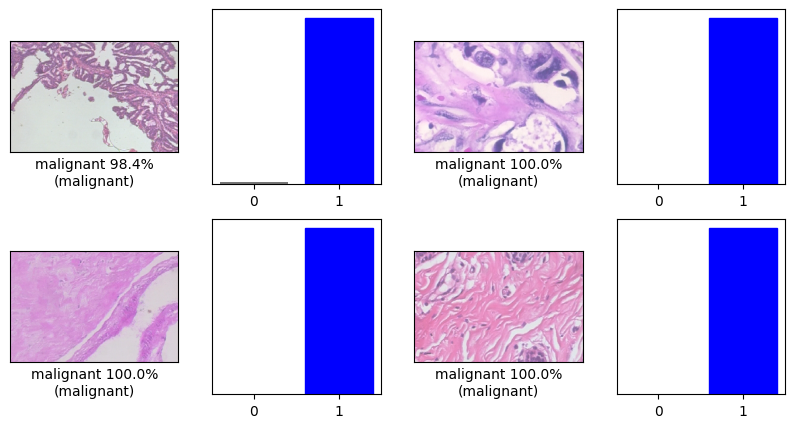

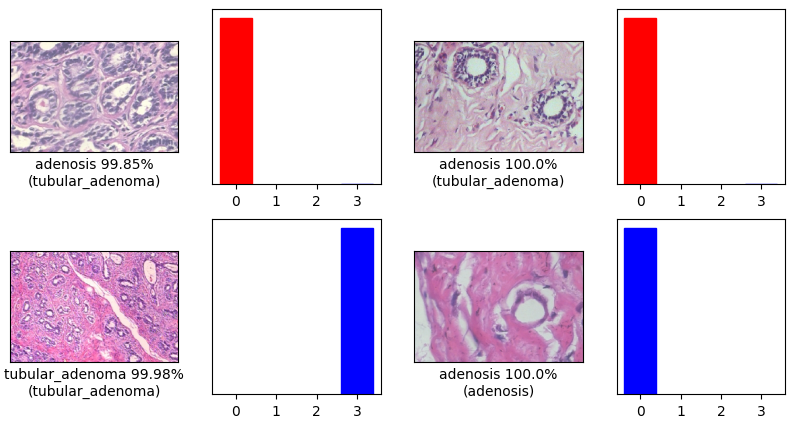

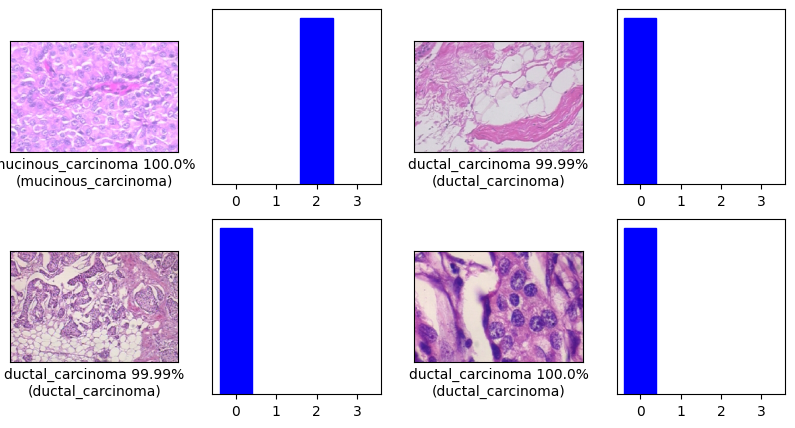

In [69]:
model_name = deep_models[3]
for i in range(len(keys)):
    plot_results(
        [random.randint(0, len(x_tests[i])) for _ in range(16)],
        x_tests[i],
        y_tests_categorical[i],
        deep_models_results[keys[i]][model_name]["predictions"],
        encoders[i]
    )


Binary model's accuracy: 0.9456384323640961



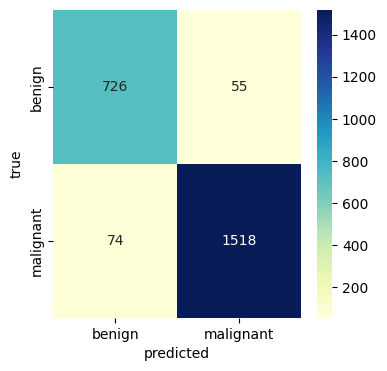




Benign model's accuracy: 0.5456989247311828



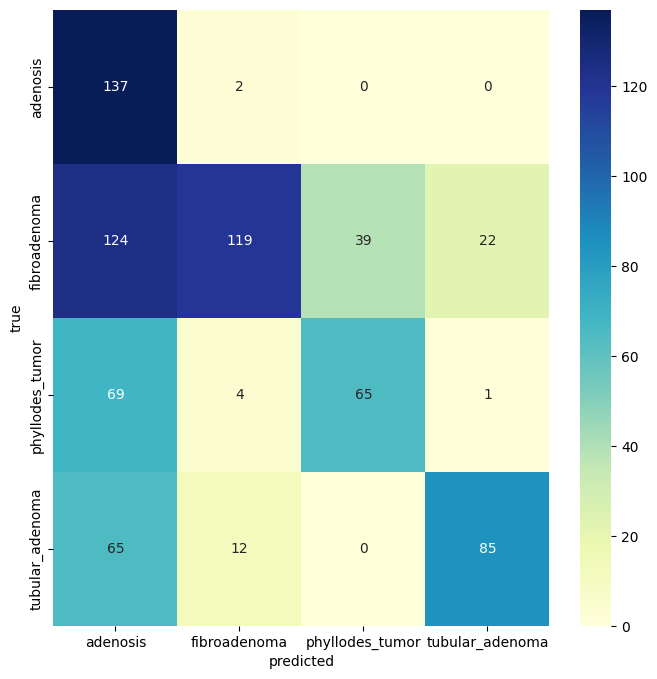




Malignant model's accuracy: 0.8833640270104358



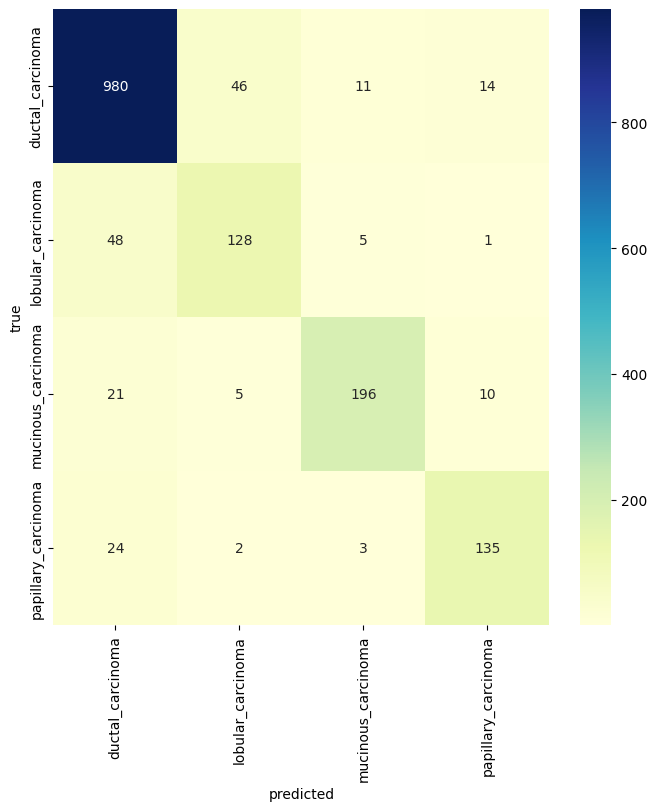

In [74]:
model_name = deep_models[3]
print()
for i in range(len(keys)):
    print(
        keys[i].capitalize() + " model's accuracy: " + str(deep_models_results[keys[i]][model_name]["accuracy"]),
        end="\n\n"
    )
    plot_confusion_matrix(
        deep_models_results[keys[i]]["y_true"],
        deep_models_results[keys[i]][model_name]["y_predicted"],
        labels[i]
    )
    print("\n\n")

# Comparision of Results

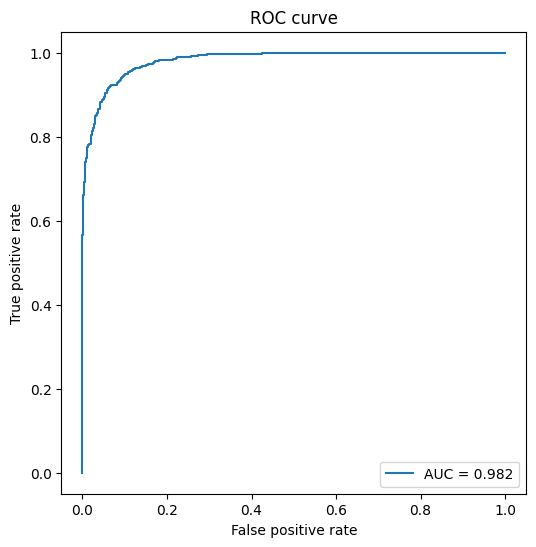

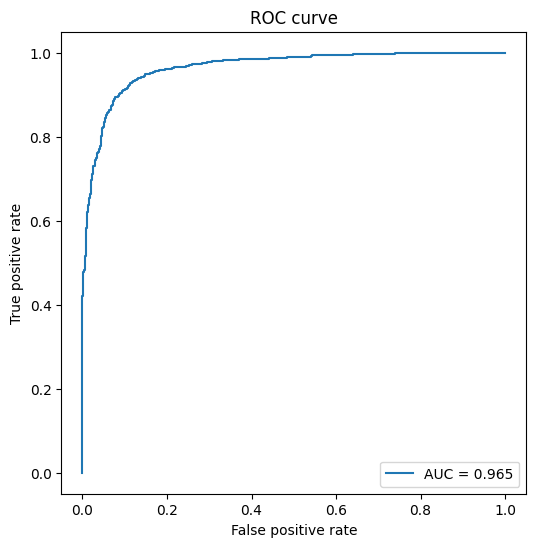

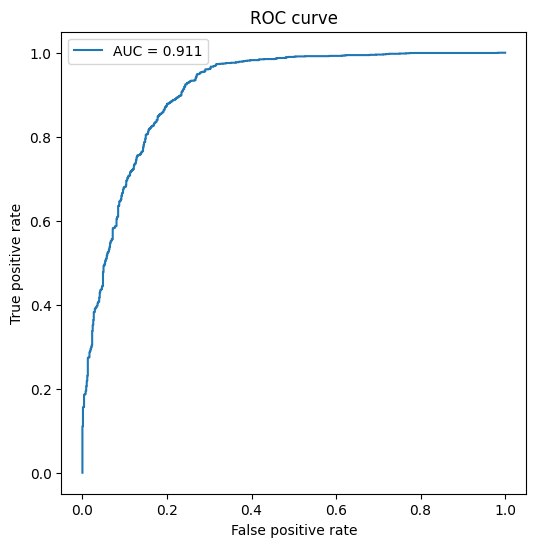

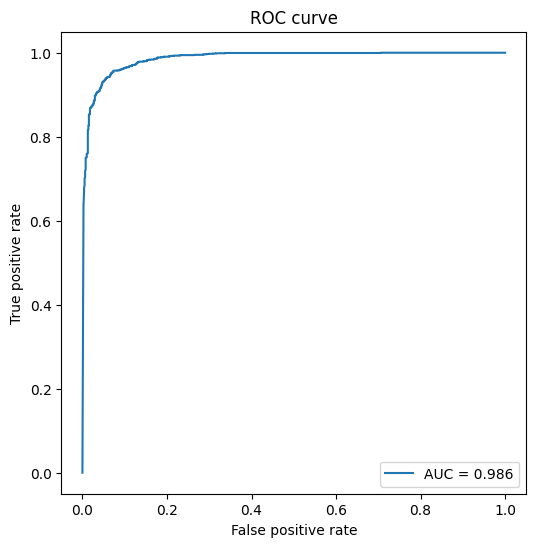

In [45]:
for i in range(0,4):
    model_name = deep_models[i]
    plot_roc_curve(
        deep_models_results["binary"]["y_true"],
        [np.max(array) for array in deep_models_results["binary"][model_name]["predictions"][:, 1]]
    )

In [80]:
print(precisions)

def calculate_f1_score(precision, recall):
    if precision == 0 and recall == 0:
        return 0.0
    else:
        return 2 * (precision * recall) / (precision + recall)
f1_scores = []
for i in range(len(precisions)):
    f1_scores.append([
        calculate_f1_score(precisions[i][j], recalls[i][j])
        for j in range(len(precisions[i]))
    ])

print('f1_scores are:')
print("\n")
print(f1_scores)


[[0.9331306990881459, 0.7514450867052023, 0.7242524916943521, 0.7916666666666666], [0.7466467958271237, 0.6608695652173913, 0.5196078431372549, 0.5428571428571428], [0.7233115468409586, 0.5588235294117647, 0.5423728813559322, 0.5274725274725275], [0.9133271202236719, 0.7071823204419889, 0.9116279069767442, 0.84375]]
f1_scores are:


[[0.9038272816486753, 0.7323943661971831, 0.8180112570356471, 0.8012048192771085], [0.8374425407438362, 0.5117845117845118, 0.31736526946107785, 0.3247863247863248], [0.8204283360790774, 0.4014084507042254, 0.21993127147766323, 0.37647058823529417], [0.9227871939736346, 0.7052341597796143, 0.8769574944071589, 0.8333333333333331]]



Binary classification: 
Accuracy of the breastnet classifier: 0.8137378845343447
Accuracy of the vgg16 classifier: 0.9085545722713865
Accuracy of the vgg19 classifier: 0.8702064896755162
Accuracy of the inception-resnet classifier: 0.9456384323640961



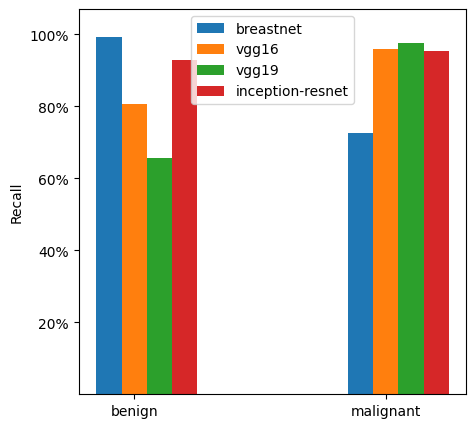

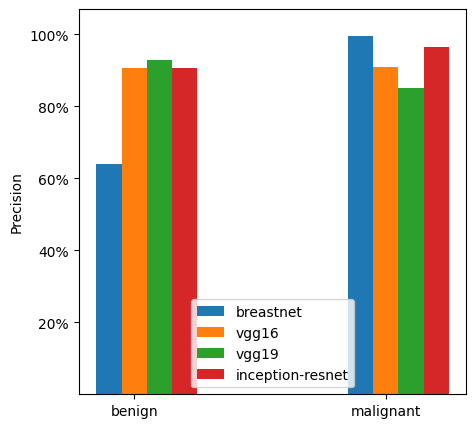




Benign classification: 
Accuracy of the breastnet classifier: 0.7728494623655914
Accuracy of the vgg16 classifier: 0.40860215053763443
Accuracy of the vgg19 classifier: 0.46102150537634407
Accuracy of the inception-resnet classifier: 0.5456989247311828



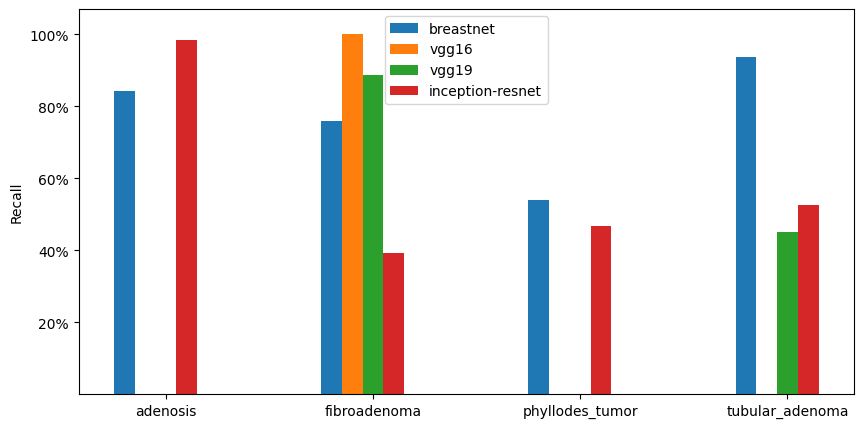

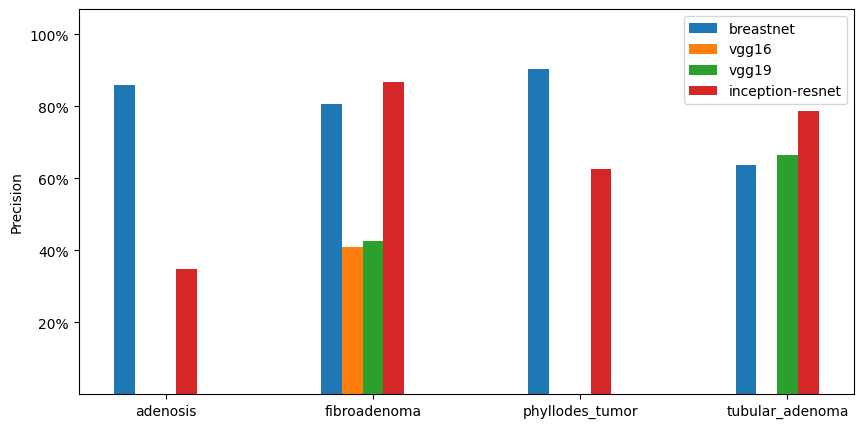




Malignant classification: 
Accuracy of the breastnet classifier: 0.8606507059545734
Accuracy of the vgg16 classifier: 0.7176181706568447
Accuracy of the vgg19 classifier: 0.6955187231430325
Accuracy of the inception-resnet classifier: 0.8833640270104358



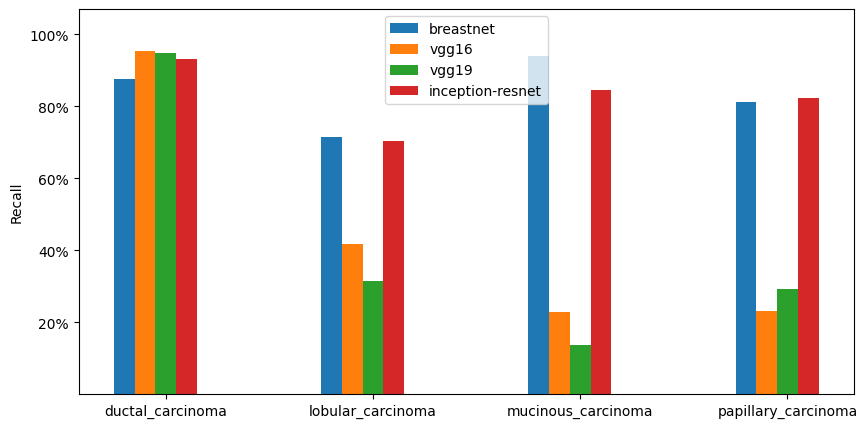

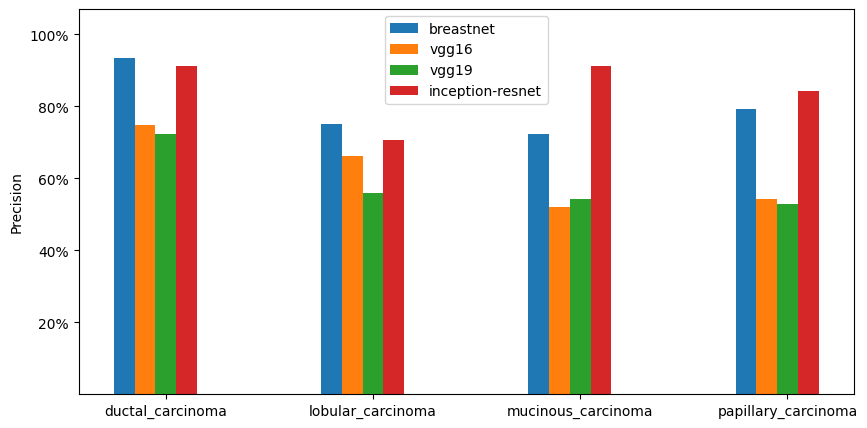

In [78]:
print()
for i in range(len(keys)):
    print(keys[i].capitalize() + " classification: ")
    for deep_model in deep_models:
        print("Accuracy of the " + deep_model + " classifier: " + 
            str(deep_models_results[keys[i]][deep_model]["accuracy"])
        )
    recalls = [deep_models_results[keys[i]][deep_model]["recalls"] for deep_model in deep_models]
    plot_stats(
        recalls,
        deep_models,
        labels[i],
        "Recall",
        n_classes[i]
    )
    print()
    precisions = [deep_models_results[keys[i]][deep_model]["precisions"] for deep_model in deep_models]
    plot_stats(
        precisions,
        deep_models,
        labels[i],
        "Precision",
        n_classes[i]
    )
    print("\n\n")

In [89]:
deep_models_results['binary']['breastnet']['precisions']

[0.6397361912613355, 0.9956896551724138]

In [90]:
deep_models_results['binary']['vgg16']['precisions']

[0.9063400576368876, 0.9094699225729601]

In [91]:
deep_models_results['binary']['vgg19']['precisions']

[0.9292196007259528, 0.8523600439077936]

In [92]:
deep_models_results['binary']['inception-resnet']['precisions']

[0.9075, 0.965034965034965]

In [96]:
deep_models_results['binary']['breastnet']['recalls']


[0.9935979513444302, 0.7255025125628141]

In [97]:
deep_models_results['binary']['vgg16']['recalls']


[0.8053777208706786, 0.9591708542713567]

In [98]:
deep_models_results['binary']['vgg19']['recalls']

[0.6555697823303457, 0.9755025125628141]

In [99]:
deep_models_results['binary']['inception-resnet']['recalls']

[0.9295774647887324, 0.9535175879396985]

In [100]:
pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.
